In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import os
import librosa

In [3]:
# Dataset path
DATA_DIR = r"C:\Users\Sahan\Desktop\SoundClassification\SoundClassification\Data"

# Settings
MAX_LEN = 128  # Number of time steps to standardize to
SAMPLE_RATE = 22050  # Default sampling rate

X = []  # Features (spectrograms)
y = []  # Labels (class indices)
class_names = []

# Loop over each folder/class
for idx, class_folder in enumerate(os.listdir(DATA_DIR)):
    folder_path = os.path.join(DATA_DIR, class_folder)
    if not os.path.isdir(folder_path):
        continue
    
    class_names.append(class_folder)
    
    for file in os.listdir(folder_path):
        if file.endswith(".ogg"):
            file_path = os.path.join(folder_path, file)
            try:
                y_audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                mel = librosa.feature.melspectrogram(y=y_audio, sr=sr)
                mel_db = librosa.power_to_db(mel, ref=np.max)
                mel_db = (mel_db - np.min(mel_db)) / (np.max(mel_db) - np.min(mel_db))  # Normalize to [0, 1]


                # Resize: pad or crop to (128, MAX_LEN)
                if mel_db.shape[1] < MAX_LEN:
                    pad_width = MAX_LEN - mel_db.shape[1]
                    mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mel_db = mel_db[:, :MAX_LEN]

                X.append(mel_db)
                y.append(idx)

            except Exception as e:
                print(f"Error with {file_path}: {e}")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for CNN: (samples, height, width, channels)
X = X[..., np.newaxis]

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print("Classes:", class_names)

Data shape: (200, 128, 128, 1)
Labels shape: (200,)
Classes: ['101 - Dog', '102 - Rooster', '103 - Pig', '104 - Cow', '105 - Frog']


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 160
Testing samples: 40


In [5]:
import numpy as np

def print_class_distribution(labels, label=""):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{label} class distribution:")
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c} samples")
    print()

print_class_distribution(y, "Total")
print_class_distribution(y_train, "Train")
print_class_distribution(y_test, "Test")

Total class distribution:
  Class 0: 40 samples
  Class 1: 40 samples
  Class 2: 40 samples
  Class 3: 40 samples
  Class 4: 40 samples

Train class distribution:
  Class 0: 32 samples
  Class 1: 32 samples
  Class 2: 32 samples
  Class 3: 32 samples
  Class 4: 32 samples

Test class distribution:
  Class 0: 8 samples
  Class 1: 8 samples
  Class 2: 8 samples
  Class 3: 8 samples
  Class 4: 8 samples



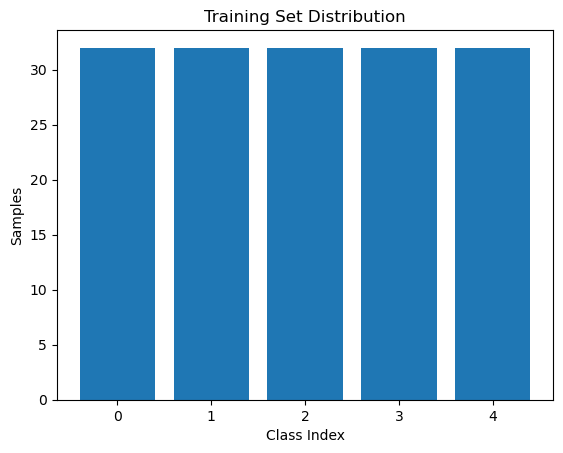

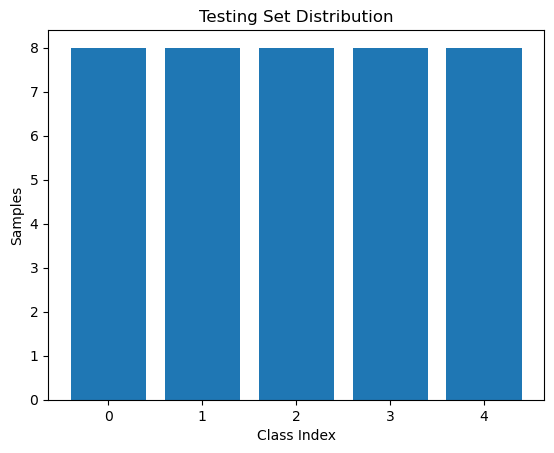

In [6]:
import matplotlib.pyplot as plt

def plot_distribution(labels, title):
    classes, counts = np.unique(labels, return_counts=True)
    plt.bar(classes, counts)
    plt.title(title)
    plt.xlabel("Class Index")
    plt.ylabel("Samples")
    plt.show()

plot_distribution(y_train, "Training Set Distribution")
plot_distribution(y_test, "Testing Set Distribution")

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Number of classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test)
)

Epoch 1/10
10/10 [==============================] - 3s 181ms/step - loss: 1.8084 - accuracy: 0.2625 - val_loss: 1.5276 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 1s 145ms/step - loss: 1.4172 - accuracy: 0.4812 - val_loss: 1.2197 - val_accuracy: 0.5500
Epoch 3/10
10/10 [==============================] - 1s 149ms/step - loss: 1.1058 - accuracy: 0.5688 - val_loss: 0.9430 - val_accuracy: 0.6000
Epoch 4/10
10/10 [==============================] - 1s 149ms/step - loss: 0.9237 - accuracy: 0.6438 - val_loss: 1.0808 - val_accuracy: 0.6000
Epoch 5/10
10/10 [==============================] - 1s 147ms/step - loss: 0.7699 - accuracy: 0.6875 - val_loss: 0.6284 - val_accuracy: 0.8500
Epoch 6/10
10/10 [==============================] - 1s 144ms/step - loss: 0.5263 - accuracy: 0.8313 - val_loss: 0.6551 - val_accuracy: 0.7500
Epoch 7/10
10/10 [==============================] - 1s 141ms/step - loss: 0.4768 - accuracy: 0.8500 - val_loss: 0.7364 - val_accuracy: 0.7000
Epoch 

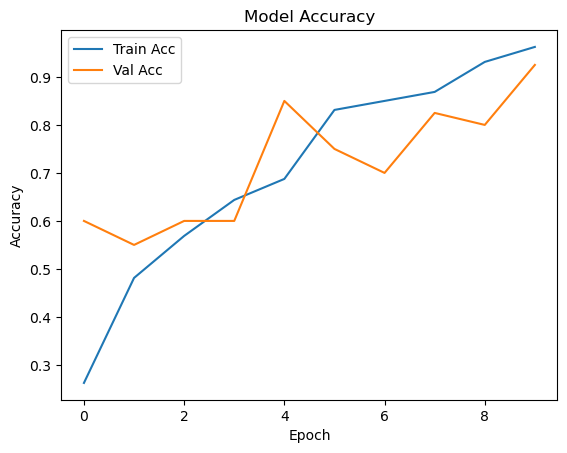

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()